In [1]:
#Import and Install Dependencies
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [2]:
pwd

'C:\\Users\\Soldo\\Desktop\\BirdNet'

In [3]:
BLRA_FILE = 'C:\\Users\\Soldo\\Desktop\\BirdNet\\Parsed_BLRA_Calls\\BR_Call_1.wav'

In [4]:
NOT_BLRA_FILE = 'C:\\Users\\Soldo\\Desktop\\BirdNet\\Parsed_Not_BLRA_Clips\\afternoon-birds-song-in-forest-0.wav'

In [5]:
#Build Data Loading Function
def load_wav_16k_mono(file_name):
    #Load encoded wav file
    file_contents = tf.io.read_file(file_name)
    # Decode wav (tensor by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hx - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [6]:
# Plot Wave
wave = load_wav_16k_mono(BLRA_FILE)

In [7]:
nwave = load_wav_16k_mono(NOT_BLRA_FILE)

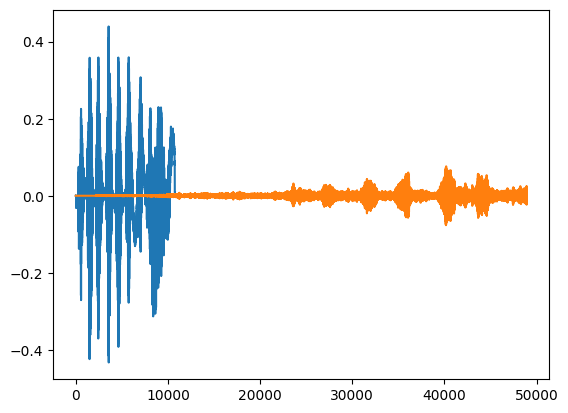

In [8]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [9]:
pwd

'C:\\Users\\Soldo\\Desktop\\BirdNet'

In [10]:
POS = 'C:\\Users\\Soldo\\Desktop\\BirdNet\\Parsed_BLRA_Calls'
NEG = 'C:\\Users\\Soldo\\Desktop\\BirdNet\\Parsed_Not_BLRA_Clips'

In [11]:
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

In [12]:
pos.as_numpy_iterator().next()

b'C:\\Users\\Soldo\\Desktop\\BirdNet\\Parsed_BLRA_Calls\\BR_Call_6.wav'

In [13]:
len(pos)

6

In [14]:
len(neg)

593

In [15]:
# Add labels and combine positive and negative samples
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [16]:
# Determine the average length of a black rail call
# Calculate wave cycle length
lengths=[]
for file in os.listdir(POS):
    tensor_wave = load_wav_16k_mono(os.path.join(POS, file))
    lengths.append(len(tensor_wave))

In [17]:
lengths

[10753, 10236, 10017, 10114, 7342, 12631]

In [18]:
# Calculate Mean, Min, and Max
mean = tf.math.reduce_mean(lengths)
min = tf.math.reduce_min(lengths)
max = tf.math.reduce_max(lengths)

print(mean, min, max)

tf.Tensor(10182, shape=(), dtype=int32) tf.Tensor(7342, shape=(), dtype=int32) tf.Tensor(12631, shape=(), dtype=int32)


In [19]:
# Build preprocessing function to convert to spectrogram
# Build preprocessing function

def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:12000]
    zero_padding = tf.zeros([12000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [20]:
# Test out the function and viz of the spectrogram
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [21]:
spectrogram, label = preprocess(filepath, label)

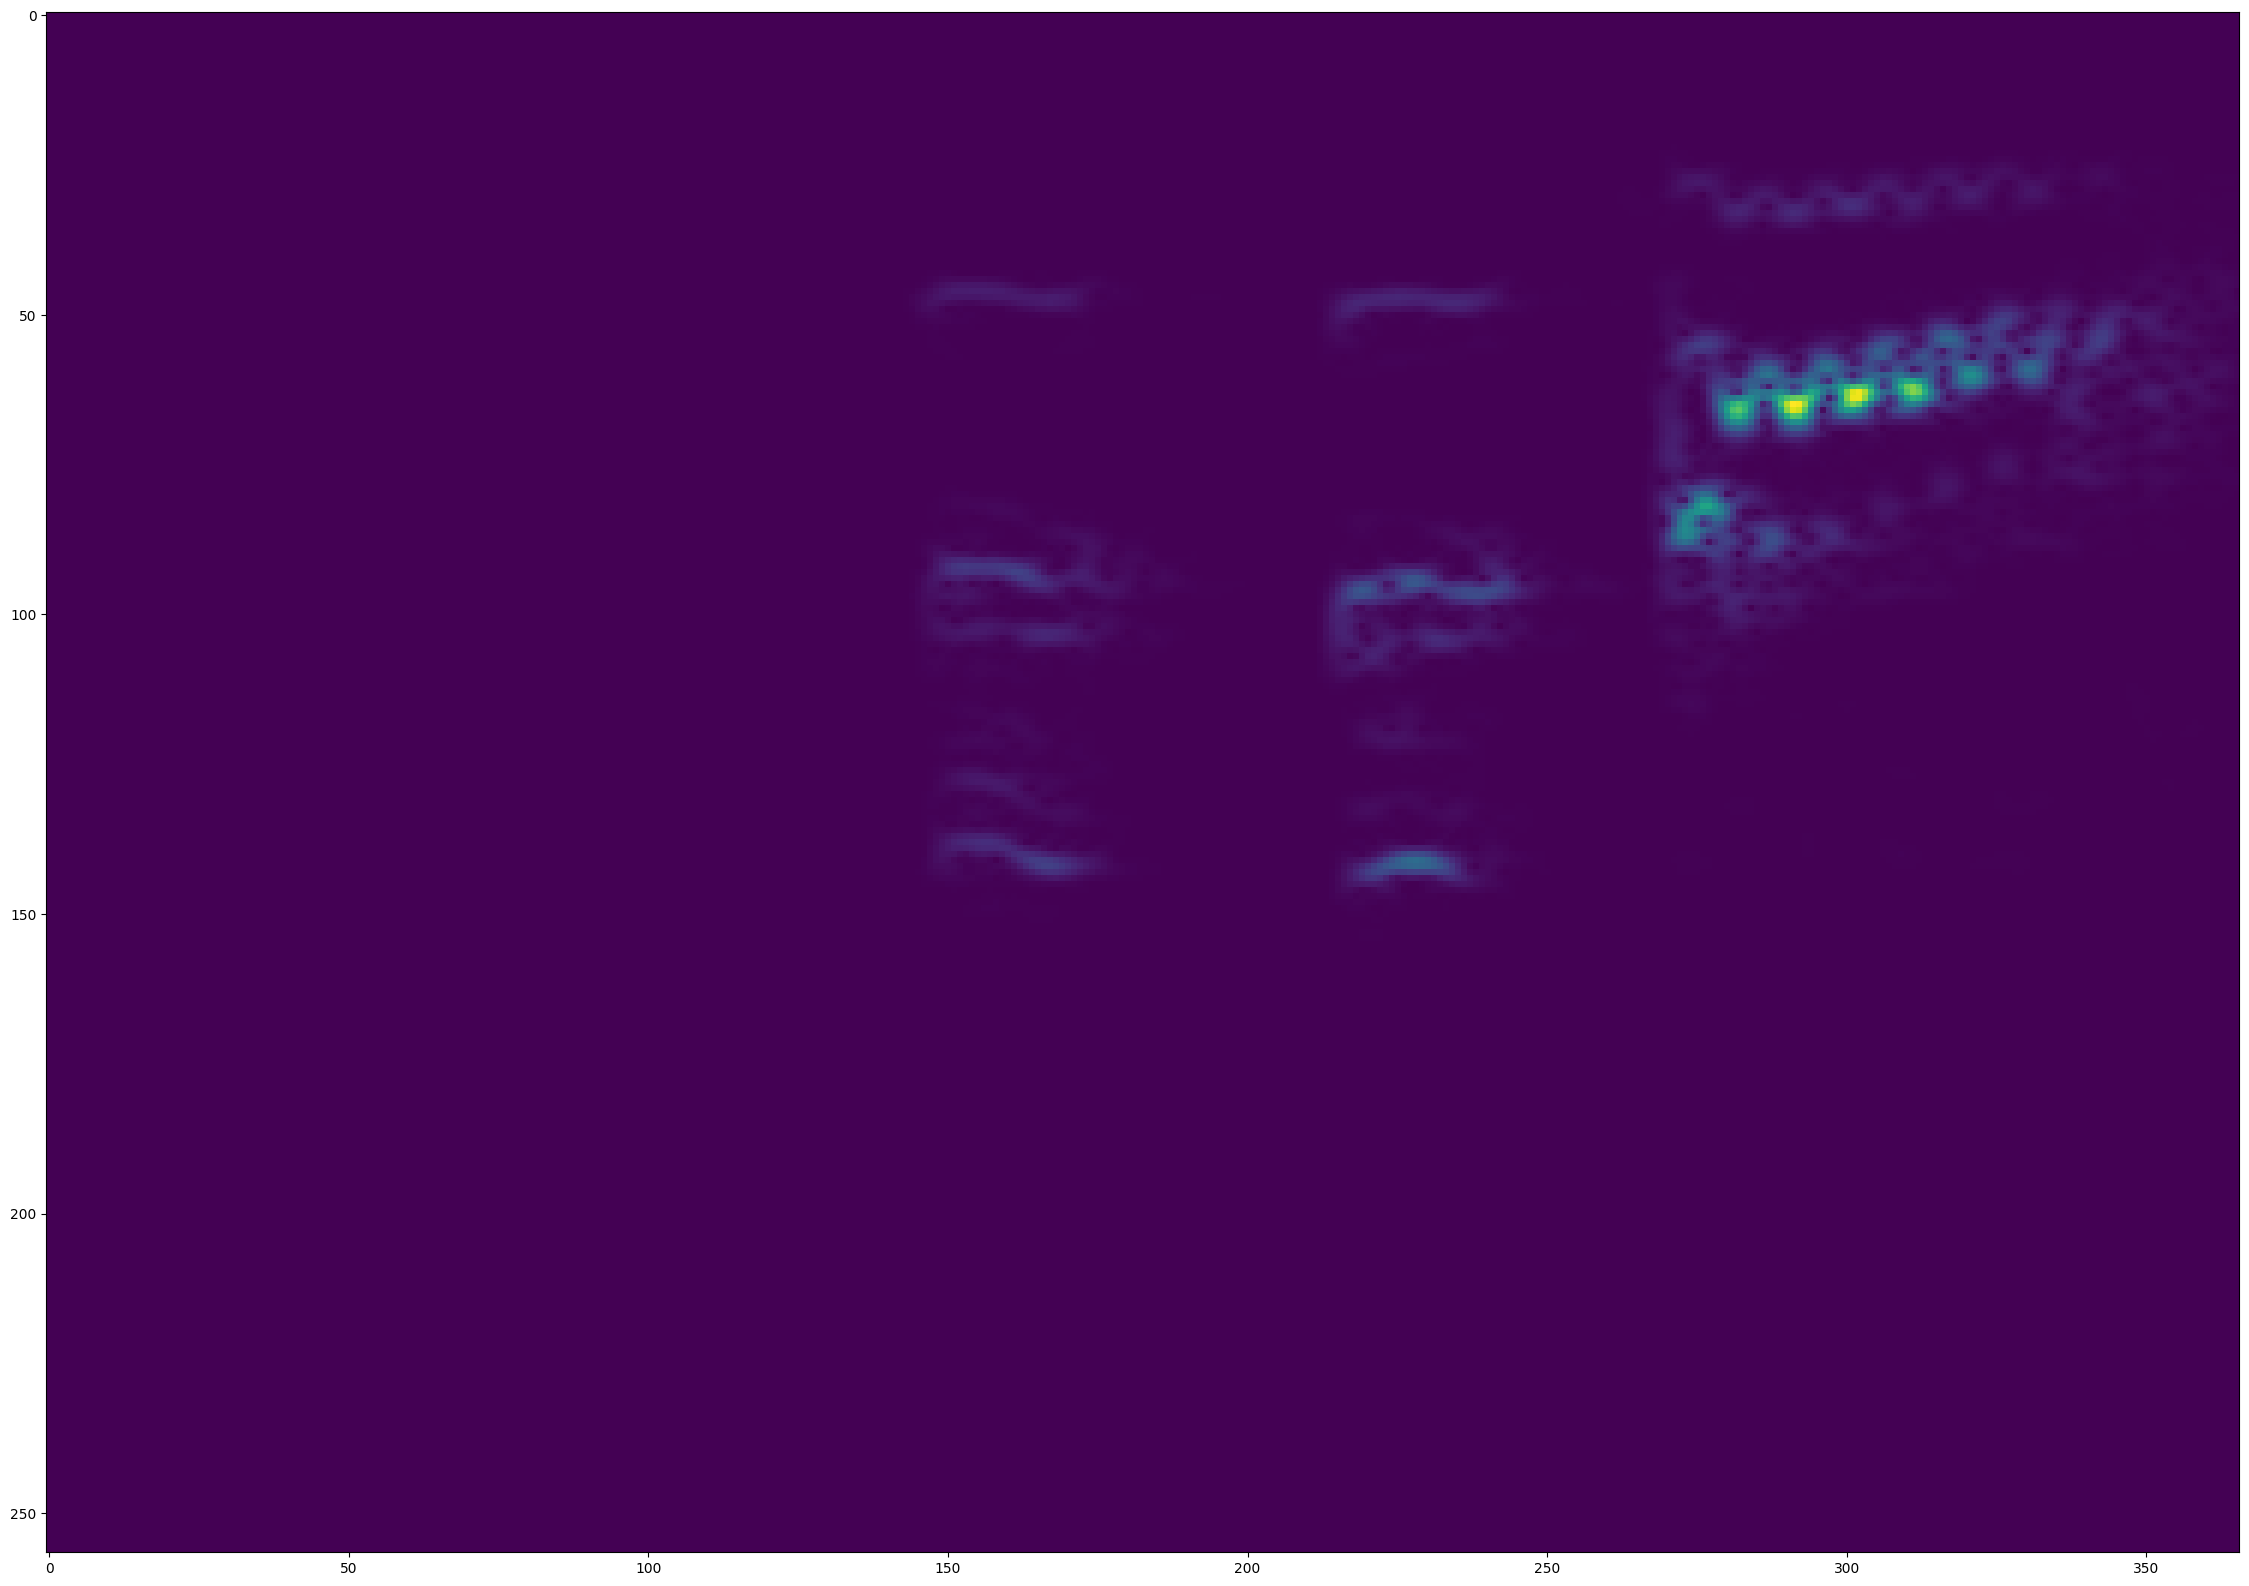

In [22]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [23]:
# Create training and testing partitions
# Create a tensorflow data pipeline

data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [24]:
# Split into training and testing partitions
len(data)

38

In [25]:
train = data.take(20)
test = data.skip(20).take(18)

In [26]:
# Test One Batch
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 366, 257, 1)

In [27]:
# Build Deep Learning Model
# Load Tensorflow Dependencies
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [28]:
# Build sequential model, compile and view summary
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(366, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 364, 255, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 362, 253, 16)      2320      
                                                                 
 flatten (Flatten)           (None, 1465376)           0         
                                                                 
 dense (Dense)               (None, 128)               187568256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 187,570,865
Trainable params: 187,570,865
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Fit Model, View Loss and KPI Plots
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
20/20 [==============================] - 58s 3s/step - loss: 4.2364 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0825 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/4
20/20 [==============================] - 54s 3s/step - loss: 0.0396 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0055 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/4
20/20 [==============================] - 54s 3s/step - loss: 0.0094 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0025 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/4
20/20 [==============================] - 55s 3s/step - loss: 0.0022 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0652 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00


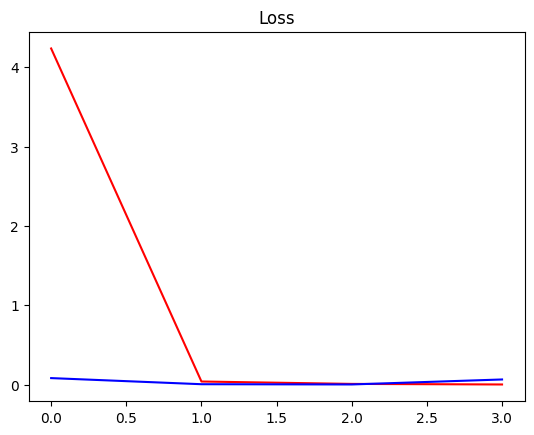

In [32]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

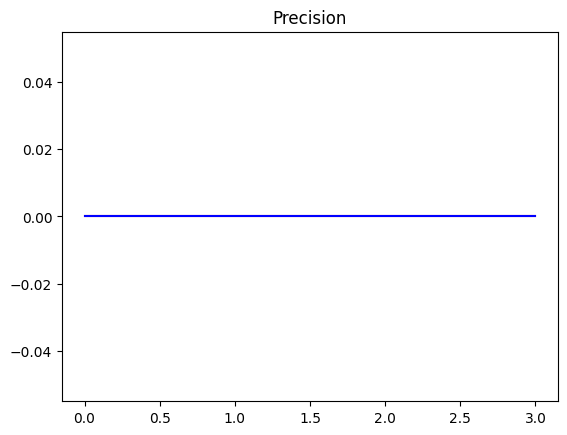

In [33]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

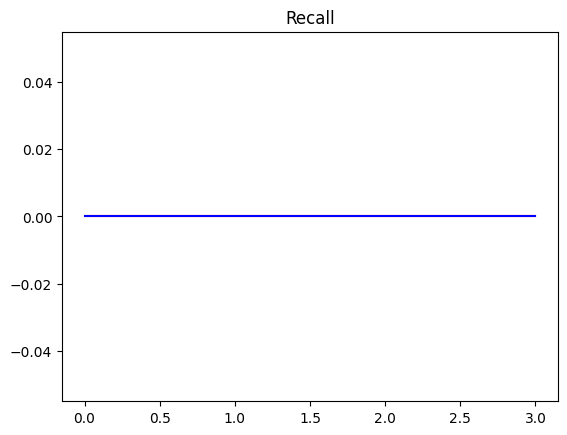

In [34]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [37]:
# Make a prediction on a single clip
# Get one batch and make a prediction
X_test, y_test = test.as_numpy_iterator().next()

In [38]:
X_test.shape

(16, 366, 257, 1)

In [39]:
y_test.shape

(16,)

In [40]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 300ms/step


In [41]:
yhat

array([[1.2544782e-21],
       [5.9415325e-15],
       [6.0714779e-34],
       [0.0000000e+00],
       [5.6195821e-15],
       [0.0000000e+00],
       [3.6208207e-31],
       [0.0000000e+00],
       [1.7617150e-38],
       [0.0000000e+00],
       [1.6061158e-17],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [4.8648115e-29],
       [0.0000000e+00]], dtype=float32)

In [42]:
# Convert Logits to Classes
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [43]:
yhat = []
for prediction in yhat:
    if prediction > 0.5:
        yhat.append(1)
        
    else:
        yhat.append(0)
        

In [44]:
yhat

[]

In [45]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [46]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [ ]:
#Build parsing functions
#Load up MP3s

def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [ ]:
wav = load_mp3_16k_mono(mp3)

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=12000, sequence_stride=12000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

In [ ]:
#Build function to convert clips into windowed spectrograms
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([12000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [ ]:
# Convert longer clips into windows and make predicitons
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=12000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.9 else 0 for prediction in yhat]

In [ ]:
# Group consecutive detections
from itertools import groupby

yaht = [key for key, group in groupby(yhat)]
tf.math.reduce_sum(yhat)
calls = tf.math.reduce_sum(yhat).numpy()
calls

In [ ]:
#Make Prediction
#Loop over all recordings and make predictions

results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=12000, sequence_stride=12000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

In [ ]:
results

In [ ]:
#Convert Predictions into Classes
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

In [ ]:
# Group Consecutive Detections
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

In [ ]:
# Export Results
import csv

with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])